In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from educational_ai_analytics.config import W_WINDOWS

BASE_PROCESSED = Path("/workspace/TFM_education_ai_analytics/data/2_processed/training")
BASE_TARGET = Path("/workspace/TFM_education_ai_analytics/data/3_features/training/target.csv")

# Carga
interactions_df = pd.read_csv(
    BASE_PROCESSED / "interactions.csv",
    index_col=None
    )

# Evitar alumnos que ya han abandonado antes de la semana objeto de predicción
students_df = pd.read_csv(BASE_PROCESSED / "students.csv", index_col=None, usecols=["code_module", "code_presentation", "id_student", "date_unregistration"])

students_df["unique_id"] = (
    students_df["id_student"].astype(str)
    .str.cat(students_df["code_module"].astype(str), sep="_")
    .str.cat(students_df["code_presentation"].astype(str), sep="_")
)

students_df["week_unregistration"] = (
    pd.to_numeric(students_df["date_unregistration"], errors="coerce").fillna(9999) // 7
).astype(int)

target_full = pd.read_csv(BASE_TARGET, index_col=0).sort_index()

# Robustez columna clicks
click_col = "sum_click" if "sum_click" in interactions_df.columns else "clicks"
if click_col not in interactions_df.columns:
    raise ValueError("No se encontró ni 'sum_click' ni 'clicks' en interactions.csv")

# Limpieza y unique_id
interactions_df["activity_type"] = interactions_df["activity_type"].astype(str).str.strip().str.lower()
interactions_df["unique_id"] = (
    interactions_df["id_student"].astype(str)
    .str.cat(interactions_df["code_module"].astype(str), sep="_")
    .str.cat(interactions_df["code_presentation"].astype(str), sep="_")
)

# Semana 0-based
interactions_df["week"] = (
    pd.to_numeric(interactions_df["date"], errors="coerce").fillna(-9999) // 7
).astype(int)

# Base temporal válida
interactions_base = interactions_df[interactions_df["week"] >= 0].copy()

# Actividades globales (mismo F para todas las ventanas)
activities_global = sorted(interactions_base["activity_type"].unique().tolist())

sequences = {f"upto_{w}": None for w in sorted(W_WINDOWS)}
masks = {f"upto_{w}": None for w in sorted(W_WINDOWS)}
labels = {f"upto_{w}": None for w in sorted(W_WINDOWS)}
ids = {f"upto_{w}": None for w in sorted(W_WINDOWS)}

for upto_week in sorted(W_WINDOWS):
    inter_uptoW = interactions_base[interactions_base["week"] < upto_week].copy()
    active_students = students_df[students_df["week_unregistration"] >=upto_week]
    valid_ids = active_students["unique_id"].unique()
    total_students = inter_uptoW["unique_id"].nunique()
    print(f"Se van a eliminar {total_students - len(valid_ids) } estudiantes por abandonar antes de la semana {upto_week}")
    inter_uptoW = inter_uptoW[inter_uptoW["unique_id"].isin(valid_ids)]

    g = (
        inter_uptoW.groupby(["unique_id", "week", "activity_type"], as_index=False)[click_col]
        .sum()
        .rename(columns={click_col: "sum_click"})
    )

    weeks = list(range(upto_week))
    full_cols = pd.MultiIndex.from_product(
        [weeks, activities_global], names=["week", "activity_type"]
    )

    wide = (
        g.pivot_table(
            index="unique_id",
            columns=["week", "activity_type"],
            values="sum_click",
            aggfunc="sum",
            fill_value=0,
        )
        .reindex(columns=full_cols, fill_value=0)
        .sort_index()
    )

    # Orden estable basado en target (mejor para trazabilidad y evaluación)
    common_ids = target_full.index.intersection(wide.index)
    wide_w = wide.loc[common_ids]
    target_w = target_full.loc[common_ids]



    X_seq = wide_w.values.reshape(len(wide_w), upto_week, len(activities_global)).astype(np.float32)
    mask = (X_seq.sum(axis=2) > 0).astype(np.int32)
    y = target_w["final_result"].astype(np.int64).values

    key = f"upto_{upto_week}"
    sequences[key] = X_seq
    masks[key] = mask
    labels[key] = y
    ids[key] = common_ids

    print(f"======== WEEK {upto_week} ========")
    print("X_seq:", X_seq.shape)
    print("mask :", mask.shape)
    print("y    :", y.shape)
    print("n_activities:", len(activities_global))
    print("classes:", np.unique(y, return_counts=True))
    print("================================")

# Ejemplo de consumo consistente:
W_KEY = f"upto_{sorted(W_WINDOWS)[0]}"
X = sequences[W_KEY]
M = masks[W_KEY]
y = labels[W_KEY]
uid = ids[W_KEY]

print("\nW_KEY:", W_KEY, "| X:", X.shape, "| M:", M.shape, "| y:", y.shape, "| ids:", len(uid))

Se van a eliminar 530 estudiantes por abandonar antes de la semana 5
======== WEEK 5 ========
X_seq: (18300, 5, 20)
mask : (18300, 5)
y    : (18300,)
n_activities: 20
classes: (array([0, 1, 2, 3]), array([3206, 4478, 8519, 2097]))
Se van a eliminar 1576 estudiantes por abandonar antes de la semana 10
======== WEEK 10 ========
X_seq: (17735, 10, 20)
mask : (17735, 10)
y    : (17735,)
n_activities: 20
classes: (array([0, 1, 2, 3]), array([2463, 4572, 8591, 2109]))
Se van a eliminar 2263 estudiantes por abandonar antes de la semana 15
======== WEEK 15 ========
X_seq: (17130, 15, 20)
mask : (17130, 15)
y    : (17130,)
n_activities: 20
classes: (array([0, 1, 2, 3]), array([1830, 4585, 8606, 2109]))
Se van a eliminar 2877 estudiantes por abandonar antes de la semana 20
======== WEEK 20 ========
X_seq: (16577, 20, 20)
mask : (16577, 20)
y    : (16577,)
n_activities: 20
classes: (array([0, 1, 2, 3]), array([1256, 4598, 8612, 2111]))
Se van a eliminar 3527 estudiantes por abandonar antes de la 

## Features derivadas del clustering

In [ ]:
from pathlib import Path
from educational_ai_analytics.config import W_WINDOWS
import pandas as pd 
import numpy as np

BASE_SEGMENTED = Path("/workspace/TFM_education_ai_analytics/data/5_students_segmented")

features_cluster = [
    'p_cluster_0', 'p_cluster_1', 'p_cluster_2', 
    'p_cluster_3', 'p_cluster_4', 'entropy_norm'
]

static_data = {f"upto_{w}": None for w in sorted(W_WINDOWS)}

for upto_week in sorted(W_WINDOWS):
    W_KEY = f"upto_{upto_week}"
    file_path = BASE_SEGMENTED / 'training' / f"students_segmented_uptoW{upto_week}.csv"
    
    cols_to_load = ["unique_id"] + features_cluster
    segmented_df = pd.read_csv(file_path, usecols=cols_to_load)
    segmented_df.set_index("unique_id", inplace=True)

    uid_w = ids[W_KEY]

    X_static_df = segmented_df.reindex(uid_w).fillna(0)
    
    static_data[W_KEY] = X_static_df.values.astype(np.float32)
    
    print(f"Procesada ventana {W_KEY}: {static_data[W_KEY].shape}")
    del segmented_df

Procesada ventana upto_5: (18300, 6)
Procesada ventana upto_10: (17735, 6)
Procesada ventana upto_15: (17130, 6)
Procesada ventana upto_20: (16577, 6)
Procesada ventana upto_25: (15962, 6)


In [13]:
import tensorflow as tf
from tensorflow.keras import layers

# =========================
# Positional Encoding (sin/cos intercalado)
# =========================
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model: int, max_len: int = 512, name=None):
        super().__init__(name=name)
        if d_model % 2 != 0:
            raise ValueError("d_model debe ser par para positional encoding sinusoidal estándar")

        pos = tf.range(max_len, dtype=tf.float32)[:, tf.newaxis]  # (L,1)
        i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]    # (1,D)

        angle_rates = 1.0 / tf.pow(10000.0, (2.0 * tf.floor(i / 2.0)) / tf.cast(d_model, tf.float32))
        angle_rads = pos * angle_rates  # (L,D)

        # Intercalado sin/cos: [sin0, cos0, sin1, cos1, ...]
        sin = tf.sin(angle_rads[:, 0::2])  # (L, D/2)
        cos = tf.cos(angle_rads[:, 1::2])  # (L, D/2)
        pe = tf.reshape(tf.stack([sin, cos], axis=-1), (max_len, d_model))  # (L,D)

        self.pe = pe[tf.newaxis, ...]  # (1,L,D)

    def call(self, x):
        # x: (B,W,D)
        w = tf.shape(x)[1]
        return x + self.pe[:, :w, :]


# =========================
# GLU (Gated Linear Unit)
# =========================
class GLULayer(layers.Layer):
    """Dense(2*units) -> split -> a * sigmoid(b)"""
    def __init__(self, units: int, name=None):
        super().__init__(name=name)
        self.proj = layers.Dense(2 * units)

    def call(self, x):
        z = self.proj(x)
        a, b = tf.split(z, num_or_size_splits=2, axis=-1)
        return a * tf.sigmoid(b)


# =========================
# Encoder Block (Pre-LN + mask (B,W,W) + FFN GLU)
# =========================
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, d_model: int, num_heads: int, ff_dim: int, dropout: float, name=None):
        super().__init__(name=name)
        if d_model % num_heads != 0:
            raise ValueError("d_model debe ser divisible por num_heads")

        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout,
        )

        self.norm_attn = layers.LayerNormalization(epsilon=1e-6)
        self.norm_ffn  = layers.LayerNormalization(epsilon=1e-6)

        self.drop_attn = layers.Dropout(dropout)
        self.drop_ffn  = layers.Dropout(dropout)

        # FFN: d_model -> ff_dim (con gating GLU) -> d_model  <---- (Reemplaza a ReLU)
        self.ffn_glu = GLULayer(units=ff_dim)
        self.ffn_out = layers.Dense(d_model)

    @staticmethod
    def make_attn_mask(seq_mask: tf.Tensor) -> tf.Tensor:
        """
        seq_mask: (B,W) int/bool, 1=valid, 0=pad
        return: (B,W,W) bool
        """
        sm = tf.cast(seq_mask, tf.bool)
        return sm[:, tf.newaxis, :] & sm[:, :, tf.newaxis]

    def call(self, x, training=False, seq_mask=None):
        if seq_mask is None:
            raise ValueError("seq_mask es obligatorio (B,W).")

        attn_mask = self.make_attn_mask(seq_mask)

        # --- Self-attention (Pre-LN) ---
        h = self.norm_attn(x)
        attn = self.mha(h, h, h, attention_mask=attn_mask, training=training)
        attn = self.drop_attn(attn, training=training)
        x = x + attn

        # --- FFN GLU (Pre-LN) ---
        h = self.norm_ffn(x)
        ffn = self.ffn_glu(h)
        ffn = self.ffn_out(ffn)
        ffn = self.drop_ffn(ffn, training=training)
        x = x + ffn

        return x


# =========================
# Modelo completo: Temporal (Transformer) + Static (cluster feats) + Head MLP
# =========================
class GLUTransformerClassifier(tf.keras.Model):
    def __init__(
        self,
        latent_d: int,
        num_heads: int,
        ff_dim: int,
        dropout: float,
        num_classes: int,
        num_layers: int = 2,
        max_len: int = 512,
        with_static_features: bool = True,
        static_hidden=(64, 64),
        head_hidden=(128, 64),
        name=None,
    ):
        super().__init__(name=name)
        self.with_static_features = with_static_features

        # ----- Temporal -----
        self.input_proj = layers.Dense(latent_d)
        self.pos_encoding = PositionalEncoding(d_model=latent_d, max_len=max_len)
        self.in_drop = layers.Dropout(dropout)

        self.encoders = [
            TransformerEncoderBlock(latent_d, num_heads, ff_dim, dropout, name=f"enc_{i}")
            for i in range(num_layers)
        ]

        # Normaliza antes de hacer el pooling promedio
        self.seq_out_norm = layers.LayerNormalization(epsilon=1e-6)
        self.pooled_norm = layers.LayerNormalization(epsilon=1e-6)

        # ----- Static -----
        if self.with_static_features:
            self.static_block = tf.keras.Sequential(
                [layers.Dense(h, activation="relu") for h in static_hidden] +
                [layers.LayerNormalization(epsilon=1e-6)],
                name="static_block"
            )
            self.fusion = layers.Concatenate(axis=-1)

        # ----- Head (MLP para Clasificación Final) -----
        head_layers = []
        for h in head_hidden:
            head_layers += [
                layers.Dropout(dropout),
                layers.Dense(h, activation="relu"),
                layers.LayerNormalization(epsilon=1e-6),
            ]
        head_layers += [
            layers.Dropout(dropout),
            layers.Dense(num_classes, activation="softmax"),
        ]
        self.head = tf.keras.Sequential(head_layers, name="head")

    def call(self, inputs, training=False):
        # inputs: (x_seq, seq_mask, x_static) o (x_seq, seq_mask)
        if not isinstance(inputs, (tuple, list)):
            raise ValueError("inputs debe ser tupla/lista: (x_seq, seq_mask[, x_static])")

        if self.with_static_features:
            if len(inputs) != 3:
                raise ValueError("Con static features: inputs=(x_seq, seq_mask, x_static)")
            x_seq, seq_mask, x_static = inputs
        else:
            if len(inputs) != 2:
                raise ValueError("Sin static features: inputs=(x_seq, seq_mask)")
            x_seq, seq_mask = inputs
            x_static = None

        if seq_mask is None:
            raise ValueError("seq_mask es obligatorio (B,W).")

        # ----- Static path -----
        if self.with_static_features:
            x_static = self.static_block(x_static, training=training)

        # ----- Temporal path -----
        x_seq = self.input_proj(x_seq)          # (B,W,D)
        x_seq = self.pos_encoding(x_seq)        # (B,W,D)
        x_seq = self.in_drop(x_seq, training=training)

        for enc in self.encoders:
            x_seq = enc(x_seq, training=training, seq_mask=seq_mask)

        x_seq = self.seq_out_norm(x_seq)

        # ----- Masked mean pooling -----
        # Mapea los pesos a cero ahí donde no hay secuencia real
        m = tf.cast(seq_mask, x_seq.dtype)[:, :, tf.newaxis]  # (B,W,1)
        pooled = tf.reduce_sum(x_seq * m, axis=1) / (tf.reduce_sum(m, axis=1) + 1e-8)
        pooled = self.pooled_norm(pooled)

        # ----- Fusion -----
        if self.with_static_features:
            z = self.fusion([pooled, x_static])
        else:
            z = pooled

        # Clasificación final
        return self.head(z, training=training)


## Binzarizar, Trinarizar o Cuaternizar el problema

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

def get_stratified_splits(sequences, masks, static_features, labels, num_classes=2, paper_baseline=True, test_size=0.2, random_state=42):
    """
    Divide los datos en entrenamiento y validación manteniendo la proporción de clases.
    Etiquetas originales: 0=Fail, 1=Withdrawn, 2=Pass, 3=Distinction
    """
    X_seq, X_mask, X_static, y = sequences.copy(), masks.copy(), static_features.copy(), labels.copy()

    if num_classes == 2:
        if paper_baseline:
            # Configuración del Paper: Abandono (1) vs Éxito (2,3). Excluye Fail (0).
            valid_mask = (y != 0)
            X_seq, X_mask, X_static, y = X_seq[valid_mask], X_mask[valid_mask], X_static[valid_mask], y[valid_mask]
            
            # Mapeo: Withdrawn (1) -> 1 (Positivo), Pass/Dist (2,3) -> 0 (Negativo)
            y_formatted = np.where(y == 1, 1, 0)
            print("Configuración 2 clases (Baseline Paper): [0: Pass/Dist] vs [1: Withdrawn]. (Fail eliminados)")
        else:
            # Tu configuración original: Fail (0) vs Éxito (2,3). Excluye Withdrawn (1).
            valid_mask = (y != 1)
            X_seq, X_mask, X_static, y = X_seq[valid_mask], X_mask[valid_mask], X_static[valid_mask], y[valid_mask]
            
            # Mapeo: Fail (0) -> 0 (Negativo), Pass/Dist (2,3) -> 1 (Positivo)
            y_formatted = np.where(y == 0, 0, 1)
            print("Configuración 2 clases (Tu Original): [0: Fail] vs [1: Pass/Dist]. (Withdrawn eliminados)")

    elif num_classes == 3:
        # Modo Trinario: Fail (0) vs Withdrawn (1) vs Éxito (2)
        y_formatted = np.where(y >= 2, 2, y)
        print("Configuración 3 clases: [0: Fail], [1: Withdrawn], [2: Pass/Dist]")

    elif num_classes == 4:
        # Modo Cuaternario: Todas las originales
        y_formatted = y
        print("Configuración 4 clases: [0: Fail], [1: Withdrawn], [2: Pass], [3: Distinction]")
    
    else:
        raise ValueError("num_classes debe ser 2, 3 o 4.")

    # Split
    (train_seq, val_seq, 
     train_mask, val_mask, 
     train_static, val_static, 
     train_labels, val_labels) = train_test_split(
        X_seq, X_mask, X_static, y_formatted,
        test_size=test_size,
        random_state=random_state,
        stratify=y_formatted
    )

    # Class weights
    unique_classes = np.unique(train_labels)
    weights_values = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
    cw = dict(zip(unique_classes, weights_values))

    return (train_seq, val_seq, train_mask, val_mask, train_static, val_static, train_labels, val_labels, cw)

In [22]:
# =========================
# CELDA 1: Splits + Normalización (seq + static) SIN LEAKAGE
# =========================
import numpy as np
from sklearn.preprocessing import StandardScaler

NUM_CLASSES = 2
W_KEY = "upto_5"
WITH_STATIC_FEATURES = True

print(f"NUM_CLASSES: {NUM_CLASSES}")
print(f"W_KEY: {W_KEY}")
print(f"WITH_STATIC_FEATURES: {WITH_STATIC_FEATURES}")

# ---- 1) Split estratificado ----
(train_seq, val_seq,
 train_mask, val_mask,
 train_static, val_static,
 train_y, val_y,
 cw) = get_stratified_splits(
    sequences=sequences[W_KEY].astype(np.float32),
    masks=masks[W_KEY].astype(np.int32),
    static_features=static_data[W_KEY].astype(np.float32),
    labels=labels[W_KEY].astype(np.int64),
    num_classes=NUM_CLASSES
)

# ---- 2) Estadística rápida de máscara (sanity) ----
active_weeks_train = train_mask.sum(axis=1)
active_weeks_val   = val_mask.sum(axis=1)
print("\n[Mask sanity]")
print("Avg active weeks (train):", float(active_weeks_train.mean()))
print("Pct <=1 active week (train):", float((active_weeks_train <= 1).mean()))
print("Avg active weeks (val):", float(active_weeks_val.mean()))
print("Pct <=1 active week (val):", float((active_weeks_val <= 1).mean()))

# ---- 3) Normalización de secuencias: log1p + z-score SOLO con semanas activas ----
train_seq_log = np.log1p(train_seq)
val_seq_log   = np.log1p(val_seq)

m_train = train_mask.astype(bool)   # (B,W)
m_val   = val_mask.astype(bool)

# Ojo: si hay estudiantes con 0 semanas activas, evitamos que reviente
if m_train.sum() == 0:
    raise ValueError("train_mask no tiene semanas activas; revisa construcción de mask.")

train_active = train_seq_log[m_train]  # (N_active, A)

mu = train_active.mean(axis=0, keepdims=True)
std = train_active.std(axis=0, keepdims=True) + 1e-8

train_seq_norm = (train_seq_log - mu) / std
val_seq_norm   = (val_seq_log   - mu) / std

# Forzamos padding a 0 para no meter basura
train_seq = train_seq_norm * train_mask[..., None]
val_seq   = val_seq_norm   * val_mask[..., None]

# ---- 4) Normalización de estáticas (fit SOLO en train) ----
if WITH_STATIC_FEATURES:
    sc_static = StandardScaler()
    train_static = sc_static.fit_transform(train_static)
    val_static   = sc_static.transform(val_static)

# ---- 5) Preparar inputs finales (como tu modelo espera) ----
final_training_set = [train_seq.astype(np.float32), train_mask.astype(np.int32)]
final_validation_set = [val_seq.astype(np.float32), val_mask.astype(np.int32)]

if WITH_STATIC_FEATURES:
    final_training_set.append(train_static.astype(np.float32))
    final_validation_set.append(val_static.astype(np.float32))

# ---- 6) Balance de clases (informativo) ----
train_classes, train_counts = np.unique(train_y, return_counts=True)
val_classes, val_counts = np.unique(val_y, return_counts=True)

print("\n" + "="*44)
print("📊 BALANCEO DE CLASES")
print("="*44)
print("Train:")
for c, n in zip(train_classes, train_counts):
    print(f"  Clase {c}: {n} ({n/len(train_y)*100:.2f}%)")
print("Val:")
for c, n in zip(val_classes, val_counts):
    print(f"  Clase {c}: {n} ({n/len(val_y)*100:.2f}%)")
print("="*44)

print("\nClass weights:", cw)

NUM_CLASSES: 2
W_KEY: upto_5
WITH_STATIC_FEATURES: True
Configuración 2 clases (Baseline Paper): [0: Pass/Dist] vs [1: Withdrawn]. (Fail eliminados)

[Mask sanity]
Avg active weeks (train): 4.2258385093167705
Pct <=1 active week (train): 0.04579710144927536
Avg active weeks (val): 4.209340841338191
Pct <=1 active week (val): 0.048029148724743294

📊 BALANCEO DE CLASES
Train:
  Clase 0: 8493 (70.34%)
  Clase 1: 3582 (29.66%)
Val:
  Clase 0: 2123 (70.32%)
  Clase 1: 896 (29.68%)

Class weights: {np.int64(0): np.float64(0.7108795478629459), np.int64(1): np.float64(1.6855108877721943)}


Pesos de clase originales:
  Clase 0: 0.7109
  Clase 1: 1.6855
Pesos de clase SUAVIZADOS:
  Clase 0: 0.8431
  Clase 1: 1.2983
Epoch 1/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 459ms/step - accuracy: 0.6301 - loss: 0.7720 - val_accuracy: 0.7314 - val_loss: 0.5599 - learning_rate: 0.0010
Epoch 2/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6583 - loss: 0.6668 - val_accuracy: 0.7327 - val_loss: 0.5610 - learning_rate: 0.0010
Epoch 3/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6880 - loss: 0.6308 - val_accuracy: 0.7314 - val_loss: 0.5610 - learning_rate: 0.0010
Epoch 4/80
41/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7018 - loss: 0.6153
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6946 - loss: 0.6177 - val_accuracy: 0.7334 - val_loss: 0.5640 - learning_rate: 0.0010
Epoch 5/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7034 - loss: 0.6095 - val_accuracy: 0.7211 - val_loss: 0.5

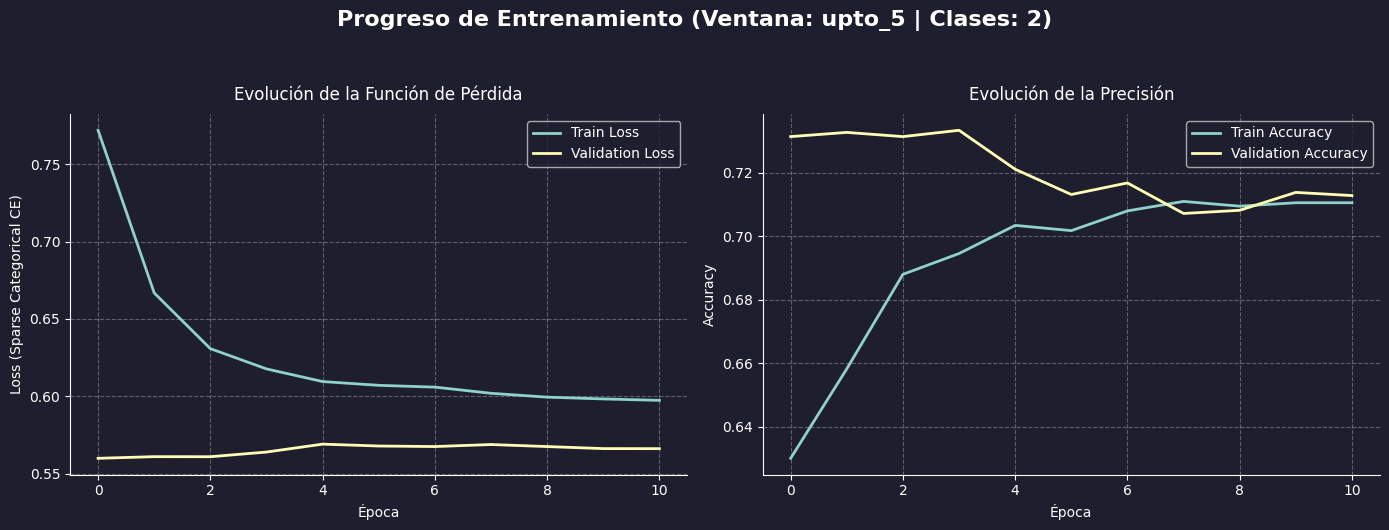

In [23]:
# =========================
# CELDA 2: Entrenar + Evaluar + Plot
# =========================
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report, balanced_accuracy_score, confusion_matrix

# ---- 0) Suavizar los Class Weights (CRÍTICO) ----
# Suavizamos los pesos con la raíz cuadrada para evitar que los gradientes
# exploten y la red aprenda a predecir sólo una clase (problema de Mode Collapse)
cw_smoothed = {k: np.sqrt(v) for k, v in cw.items()}
print("Pesos de clase originales:")
for k, v in cw.items(): print(f"  Clase {k}: {v:.4f}")
print("Pesos de clase SUAVIZADOS:")
for k, v in cw_smoothed.items(): print(f"  Clase {k}: {v:.4f}")


# ---- 1) Modelo (Micro-Transformer forzado a usar Estáticas) ----
model = GLUTransformerClassifier(
    # --- TEMPORAL ---
    # Bajamos el poder del transformer para evitar que el ruido ahogue la señal estática de clustering
    latent_d=16,                  # (Antes 256)
    num_heads=2,                  # (Antes 8)
    ff_dim=64,                    # (Antes 512)
    dropout=0.3,                  # (Antes 0.1) Subimos el dropout
    num_layers=1,                 # 1 sola pasada del Transformer (evitamos overfit masivo)
    
    # --- CONFIGURACIÓN ---
    num_classes=NUM_CLASSES, 
    max_len=final_training_set[0].shape[1],
    with_static_features=WITH_STATIC_FEATURES,
    
    # --- ESTÁTICA Y CLASIFICADOR ---
    static_hidden=[64, 32],       
    head_hidden=[64, 32]       
)


# ---- 2) Optimizer y Compilación ----
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,          # Un learning rate un poco más vivo para sacarlo del colapso
    clipnorm=1.0                 # Estabilizador esencial para evitar exploding gradients
)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


# ---- 3) Callbacks (CON EarlyStopping y LR scheduler) ----
callbacks = [
    # Reduce el Learning Rate si la validación se estanca
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    # Detiene el entrenamiento si pasan 10 épocas sin mejorar y restaura la mejor iteración
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

# ---- 4) Entrenamiento ----
history = model.fit(
    x=final_training_set,
    y=train_y,
    validation_data=(final_validation_set, val_y),
    epochs=80,
    batch_size=256,
    class_weight=cw_smoothed,    # <--- Usamos el diccionario de pesos suavizados
    callbacks=callbacks,
    verbose=1
)

# ---- 5) Evaluación ----
results = model.evaluate(final_validation_set, val_y, verbose=0)
print(f"\nLoss: {results[0]:.4f} | Accuracy: {results[1]:.4f}")

y_probs = model.predict(final_validation_set, verbose=0)
y_pred = np.argmax(y_probs, axis=1)

print("\n[Balanced Accuracy]:", balanced_accuracy_score(val_y, y_pred))
print("\n[Confusion Matrix]\n", confusion_matrix(val_y, y_pred))
print("\n[Classification Report]\n", classification_report(val_y, y_pred, digits=4))

# AUC
if NUM_CLASSES == 2:
    auc_val = roc_auc_score(val_y, y_probs[:, 1])
else:
    auc_val = roc_auc_score(val_y, y_probs, multi_class='ovr')
print(f"\nAUC (OVR): {auc_val:.4f}")
print("Mejor Accuracy en Val:", max(history.history["val_accuracy"]))

# ---- 6) Plot ----
save_dir = "/workspace/TFM_education_ai_analytics/reports/transformer_training"
os.makedirs(save_dir, exist_ok=True)

plt.style.use('dark_background')
plt.rcParams.update({"figure.facecolor": "#1e1e2e", "axes.facecolor": "#1e1e2e"})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f"Progreso de Entrenamiento (Ventana: {W_KEY} | Clases: {NUM_CLASSES})",
             fontsize=16, fontweight='bold', y=1.05)

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Evolución de la Función de Pérdida', pad=10)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (Sparse Categorical CE)')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Evolución de la Precisión', pad=10)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)

sns.despine(fig)
plt.tight_layout()

plot_path = os.path.join(save_dir, f"plot_{W_KEY}_{NUM_CLASSES}clases.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Gráfico guardado en: {plot_path}")

plt.show()


In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    balanced_accuracy_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predicción en validación
y_proba = model.predict((X_va, M_va), verbose=0)
y_pred = np.argmax(y_proba, axis=1)

# Métricas clave multiclase
macro_f1 = f1_score(y_va, y_pred, average="macro")
weighted_f1 = f1_score(y_va, y_pred, average="weighted")
bal_acc = balanced_accuracy_score(y_va, y_pred)

print(f"macro_f1     : {macro_f1:.4f}")
print(f"weighted_f1  : {weighted_f1:.4f}")
print(f"balanced_acc : {bal_acc:.4f}")
print("\nClassification report:")
print(classification_report(y_va, y_pred, digits=4))

# Matriz de confusión (absoluta)
cm = confusion_matrix(y_va, y_pred)
labels_txt = ["Withdrawn", "Fail", "Pass", "Distinction"]  # 0,1,2,3

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=labels_txt, yticklabels=labels_txt
)
plt.title("Matriz de confusión (validación)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# Matriz de confusión normalizada por clase real
cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_norm, annot=True, fmt=".2f", cmap="Greens", vmin=0, vmax=1,
    xticklabels=labels_txt, yticklabels=labels_txt
)
plt.title("Matriz de confusión normalizada (validación)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

NameError: name 'X_va' is not defined